# Comparison of Top 20 highest variable features (True vs. Prediction)

In [1]:
# Some imports
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

### GEARS data stuff

In [2]:
# GEARS
prediction_type = 'double' # or single
path_to_adata = './data/norman/perturb_processed.h5ad'
path_to_pred = './results/gears_norman_single/gears_norman_split_simulation_seed_42_hidden_size_64_decoder_hidden_size_16_double.csv'

In [3]:
# Obtain highest varying genes
adata = sc.read_h5ad(path_to_adata)


In [4]:
adata

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [5]:
splitting = adata.obs['condition'].str.split('+')
for i in range(len(splitting)):
    if len(splitting.iloc[i]) == 2:
        if 'ctrl' in splitting.iloc[i]:
            splitting.iloc[i].remove('ctrl')

join_names = splitting.apply(lambda x: '+'.join(sorted(x))) # Makes sure that order is the same
adata.obs['condition_fixed'] = join_names

# # Keeping only single perturbations
# filter_mask = ~adata.obs["condition_fixed"].str.contains(r"\+") # mask for those NOT containing +
# indexes_to_keep = filter_mask[filter_mask].index # mask that finds indeces in norman adata that aren't double perturbations


In [6]:
double = ['CEBPA', 'CEBPB']
combo = [f"{double[0]}_{double[1]}", f"{double[1]}_{double[0]}"]

# Whole pred dataframe
df = pd.read_csv(path_to_pred)

# True geps
double_adata = adata[
    (adata.obs['condition_fixed'] == combo[0].replace("_", "+")) |
    (adata.obs['condition_fixed'] == combo[1].replace("_", "+"))
].copy()
print(double_adata.n_obs)

# Ctrl geps
ctrl_adata = adata[adata.obs['condition_fixed'] == 'ctrl'].copy()

75


In [7]:
adata.obs['condition'].value_counts()

condition
ctrl             7353
CEBPE+RUNX1T1    1030
KLF1+ctrl         997
TBX3+TBX2         969
SLC4A1+ctrl       853
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
JUN+CEBPB          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: count, Length: 284, dtype: int64

In [8]:
# Get a set of control cells
# Set seed
n = double_adata.n_obs
np.random.seed(42)
random_indices = np.random.choice(ctrl_adata.n_obs, size=n, replace=False)
ctrl_set = ctrl_adata.X.toarray()[random_indices, :]

In [9]:
# Getting array for this prediction
pred_geps = df[df['double'].isin(combo)]
pred_geps = pred_geps.iloc[0, 1:].tolist()
pred_geps = np.array([pred_geps])

pred_deg = pred_geps - ctrl_set

true_deg = double_adata.X.toarray() - ctrl_set

In [10]:
top_deg = 20
topdeg_idx = np.argsort(abs(np.mean(true_deg, axis=0)))[-top_deg:]
gene_names_list = adata.var['gene_name'].iloc[topdeg_idx]

In [11]:
top_pred = pred_deg[:, topdeg_idx]
top_true = true_deg[:, topdeg_idx]

top_true = pd.DataFrame(top_true, columns=gene_names_list)
top_pred = pd.DataFrame(top_pred, columns=gene_names_list)

top_true['Type'] = 'True'
top_pred['Type'] = 'Prediction'

# Concatenate
fused_df = pd.concat([top_true, top_pred])

# Melt the DataFrame so you have long-form format for Seaborn
melted = fused_df.melt(id_vars=['Type'], var_name='Gene', value_name='value')



### scGPT data stuff

In [12]:
# scGPT
prediction_type = 'double' # or single
path_to_adata = './data/norman_alt/perturb_processed.h5ad'
path_to_pred = './results/scgpt/scgpt_norman_alt_simulation_seed_42_double.csv'

In [13]:
# Obtain highest varying genes
adata_alt = sc.read_h5ad(path_to_adata)

In [14]:
adata_alt

AnnData object with n_obs × n_vars = 67885 × 5000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_ids', 'guide_merged', 'split', 'batch', 'condition', 'cell_type', 'dose_val', 'control', 'drug_dose_name', 'cov_drug_dose_name', 'condition_fixed', 'condition_name'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [15]:
double = ['CEBPA', 'CEBPB']
combo = [f"{double[0]}_{double[1]}", f"{double[1]}_{double[0]}"]

# Whole pred dataframe
df_alt = pd.read_csv(path_to_pred)

# True geps
double_adata_alt = adata_alt[
    (adata_alt.obs['condition_fixed'] == combo[0].replace("_", "+")) |
    (adata_alt.obs['condition_fixed'] == combo[1].replace("_", "+"))
].copy()
print(double_adata_alt.n_obs)

# Ctrl geps
ctrl_adata = adata_alt[adata_alt.obs['condition_fixed'] == 'ctrl'].copy()

64


In [16]:
# Get a set of control cells
n = double_adata_alt.n_obs
np.random.seed(42)
random_indices = np.random.choice(ctrl_adata.n_obs, size=n, replace=False)
ctrl_set = ctrl_adata.X.toarray()[random_indices, :]


# Getting array for this prediction
pred_geps_alt = df_alt[df_alt['double'].isin(combo)]
pred_geps_alt = pred_geps_alt.iloc[0, 1:].tolist()
pred_geps_alt = np.array([pred_geps_alt])

pred_deg_alt = pred_geps_alt - ctrl_set

true_deg_alt = double_adata_alt.X.toarray() - ctrl_set

In [17]:
# Assuming:
# gene_names_list → pandas Series or list of gene names from adata_alt
# adata           → your other AnnData object

target_gene_names = adata_alt.var['gene_name'].values

# map
gene_to_idx = {gene: idx for idx, gene in enumerate(target_gene_names)}

# Reverse map
reverse_idx = np.array([gene_to_idx[gene] for gene in gene_names_list if gene in gene_to_idx])


In [18]:
reverse_idx

array([  90, 4796, 3828, 4657, 1456, 3084, 3942,  292, 3747, 4167, 3800,
       2103, 2891, 2699, 1776,  120, 4635, 4475, 4653, 1668])

In [19]:
top_pred_alt = pred_deg_alt[:, reverse_idx]
top_true_alt = true_deg_alt[:, reverse_idx]

top_true_alt = pd.DataFrame(top_true_alt, columns=gene_names_list)
top_pred_alt = pd.DataFrame(top_pred_alt, columns=gene_names_list)

top_true_alt['Type'] = 'True'
top_pred_alt['Type'] = 'Prediction'

# Concatenate
fused_df_alt = pd.concat([top_true_alt, top_pred_alt])

# Melt the DataFrame so you have long-form format for Seaborn
melted_alt = fused_df_alt.melt(id_vars=['Type'], var_name='Gene', value_name='value')


In [20]:
melted_alt

,Type,Gene,value
0,True,SH3BGRL3,0.338692
1,True,SH3BGRL3,1.480876
2,True,SH3BGRL3,1.381804
3,True,SH3BGRL3,0.416873
4,True,SH3BGRL3,2.132246
...,...,...,...
2555,Prediction,LST1,1.284227
2556,Prediction,LST1,2.203766
2557,Prediction,LST1,2.203766
2558,Prediction,LST1,1.858938


### SENA data stuff

In [21]:
# SENA
prediction_type = 'double' # or single
# path_to_adata = './data/norman_alt/perturb_processed.h5ad'
path_to_pred = './results/sena_new_version/CEBPA_CEBPB_prediction_sena_new_version_seed_42_latdim_105.csv'

# it uses the same adata as scgpt, adata_alt, double_adata_alt and ctrl_adata
double_adata_sena = pd.read_csv(path_to_pred)

In [30]:
# Get a set of control cells
n = double_adata_alt.n_obs
np.random.seed(42)
random_indices = np.random.choice(ctrl_adata.n_obs, size=n, replace=False)
ctrl_set = ctrl_adata.X.toarray()[random_indices, :]


# Getting array for this prediction
pred_geps_sena = np.array(double_adata_sena)

pred_deg_sena = pred_geps_sena - ctrl_set

true_deg_sena = double_adata_alt.X.toarray() - ctrl_set

In [27]:
# THIS MAP IS KEPT THE SAME AS SCGPT

#target_gene_names = adata_alt.var['gene_name'].values

# map
#gene_to_idx = {gene: idx for idx, gene in enumerate(target_gene_names)}

# Reverse map
#reverse_idx = np.array([gene_to_idx[gene] for gene in gene_names_list if gene in gene_to_idx])


In [32]:
top_pred_sena = pred_deg_sena[:, reverse_idx]
top_true_sena = true_deg_sena[:, reverse_idx]

top_true_sena = pd.DataFrame(top_true_sena, columns=gene_names_list)
top_pred_sena = pd.DataFrame(top_pred_sena, columns=gene_names_list)

top_true_sena['Type'] = 'True'
top_pred_sena['Type'] = 'Prediction'

# Concatenate
fused_df_sena = pd.concat([top_true_sena, top_pred_sena])

# Melt the DataFrame so you have long-form format for Seaborn
melted_sena = fused_df_sena.melt(id_vars=['Type'], var_name='Gene', value_name='value')

# With this, I can now use the following code to plot results


### Plotting stuff (test)

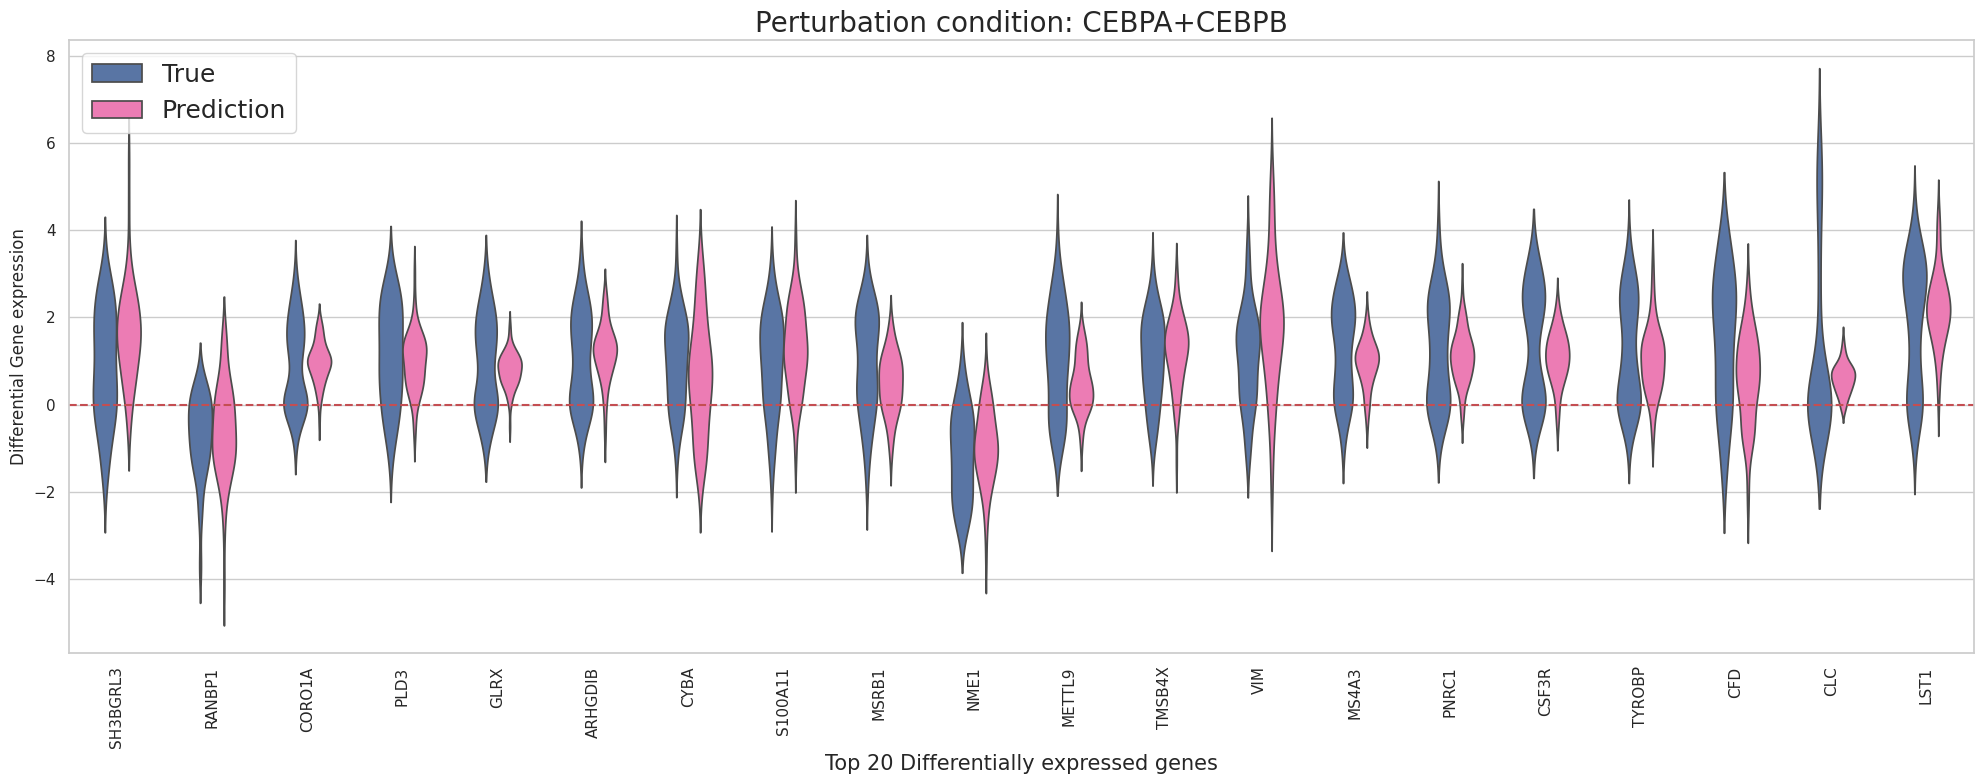

In [34]:
# Plot for SENA (careful)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
custom_palette = {"True": "#4C72B0", "Prediction": "#FF69B4"}
sns.set_theme(style="whitegrid", color_codes=True)

sns.violinplot(data=melted_sena, x='Gene', y='value', hue='Type', split=False, inner=None, width=0.5, density_norm='width', palette=custom_palette)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('Differential Gene expression')

plt.xlabel(f'Top {top_deg} Differentially expressed genes', fontsize=15)
plt.xticks(rotation=90)

plt.legend(loc = 'upper left', fontsize=18)
plt.title(f"Perturbation condition: {double[0]}+{double[1]}", fontsize = 20)

plt.tight_layout()
plt.show()

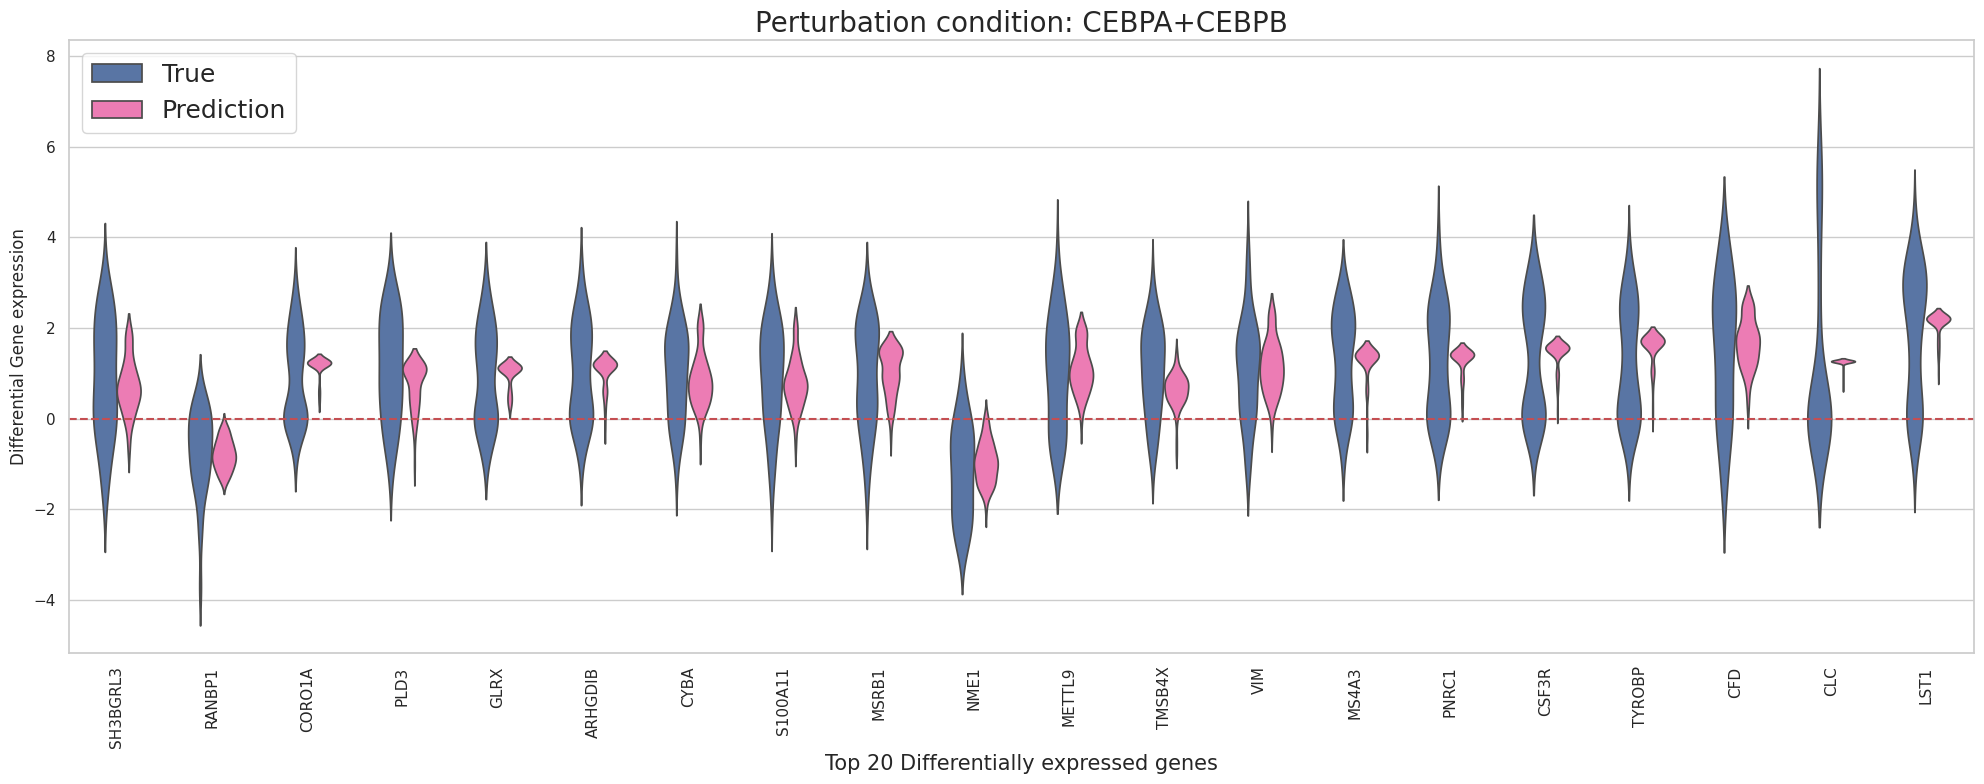

In [ ]:
# Plot for scgpt (careful)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
custom_palette = {"True": "#4C72B0", "Prediction": "#FF69B4"}
sns.set_theme(style="whitegrid", color_codes=True)

sns.violinplot(data=melted_alt, x='Gene', y='value', hue='Type', split=False, inner=None, width=0.5, density_norm='width', palette=custom_palette)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('Differential Gene expression')

plt.xlabel(f'Top {top_deg} Differentially expressed genes', fontsize=15)
plt.xticks(rotation=90)

plt.legend(loc = 'upper left', fontsize=18)
plt.title(f"Perturbation condition: {double[0]}+{double[1]}", fontsize = 20)

plt.tight_layout()
plt.show()

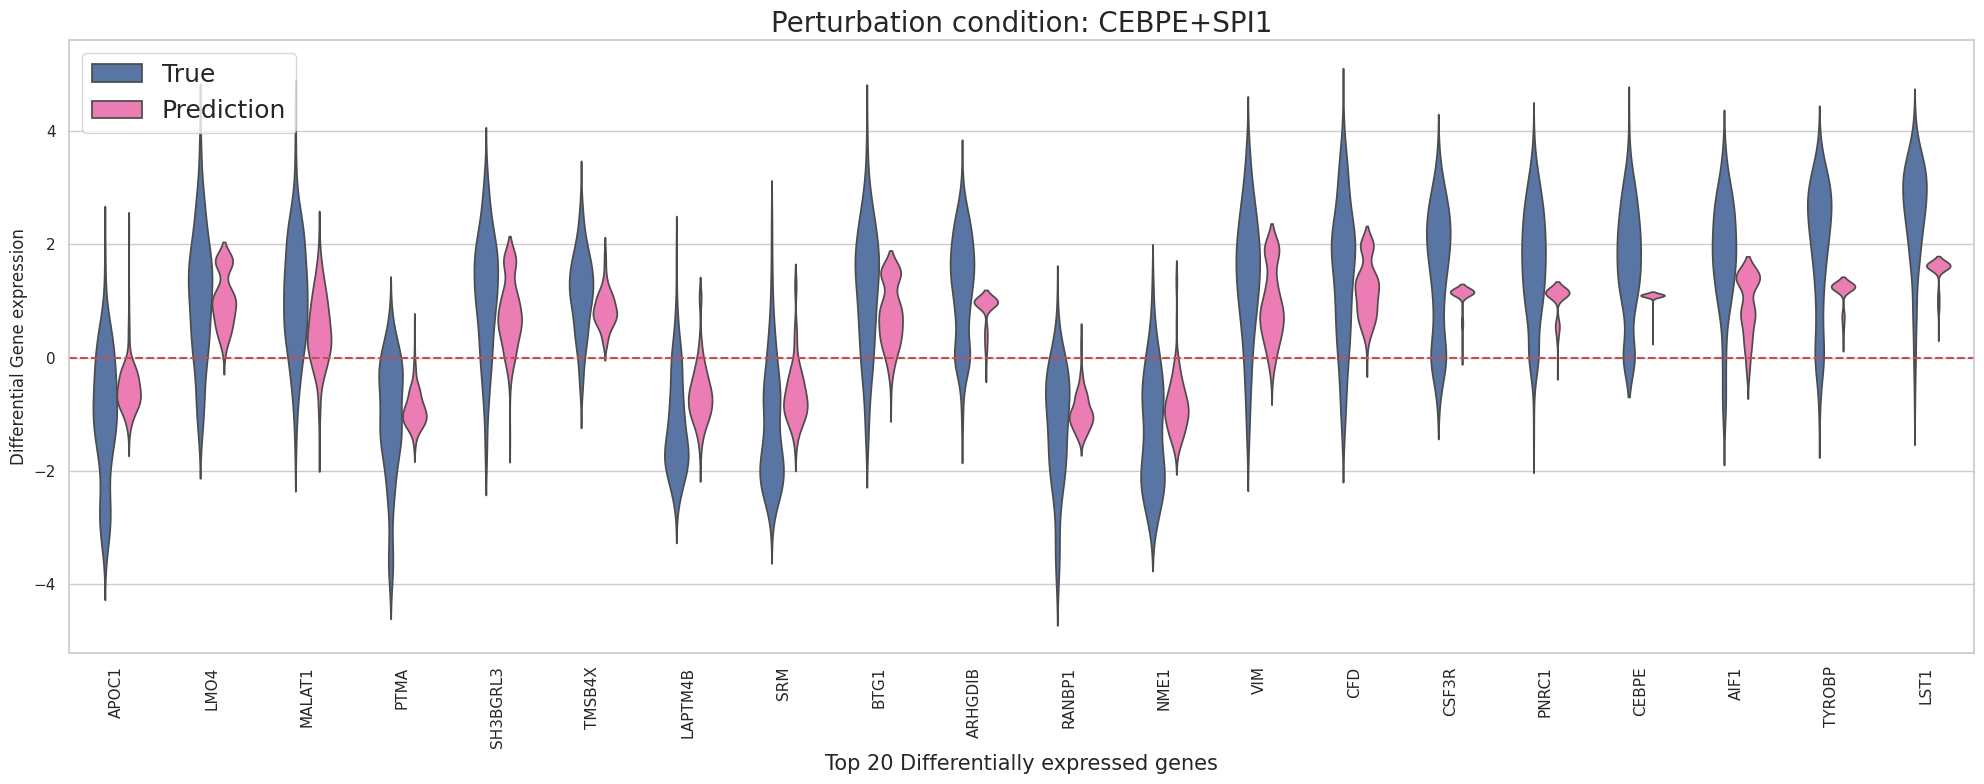

In [129]:
# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
custom_palette = {"True": "#4C72B0", "Prediction": "#FF69B4"}
sns.set_theme(style="whitegrid", color_codes=True)

sns.violinplot(data=melted, x='Gene', y='value', hue='Type', split=False, inner=None, width=0.5, density_norm='width', palette=custom_palette)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('Differential Gene expression')

plt.xlabel(f'Top {top_deg} Differentially expressed genes', fontsize=15)
plt.xticks(rotation=90)

plt.legend(loc = 'upper left', fontsize=18)
plt.title(f"Perturbation condition: {double[0]}+{double[1]}", fontsize = 20)

plt.tight_layout()
plt.show()

### Functions for above

In [38]:
def get_degs(condition, prediction_GEP, adata, top_deg: int = 20):
    combo = [f"{condition[0]}_{condition[1]}", f"{condition[1]}_{condition[0]}"]
    # True geps
    double_adata = adata[
        (adata.obs['condition_fixed'] == combo[0].replace("_", "+")) |
        (adata.obs['condition_fixed'] == combo[1].replace("_", "+"))
    ].copy()
    if double_adata.n_obs == 0:
        print("0 samples found for given condition.")
        return
    # Ctrl geps
    ctrl_adata = adata[adata.obs['condition_fixed'] == 'ctrl'].copy()

    # Get a set of control cells
    n = double_adata.n_obs
    np.random.seed(42)
    random_indices = np.random.choice(ctrl_adata.n_obs, size=n, replace=False)
    ctrl_set = ctrl_adata.X.toarray()[random_indices, :]

    # Pred geps
    pred_geps = prediction_GEP[prediction_GEP['double'].isin(combo)]
    pred_geps = pred_geps.iloc[0, 1:].tolist()
    pred_geps = np.array([pred_geps])

    # DEG
    pred_deg = pred_geps - ctrl_set
    true_deg = double_adata.X.toarray() - ctrl_set

    topdeg_idx = np.argsort(abs(np.mean(true_deg, axis=0)))[-top_deg:]
    gene_names_list = adata.var['gene_name'].iloc[topdeg_idx]

    top_pred = pred_deg[:, topdeg_idx]
    top_true = true_deg[:, topdeg_idx]

    top_true = pd.DataFrame(top_true, columns=gene_names_list)
    top_pred = pd.DataFrame(top_pred, columns=gene_names_list)

    top_true['Type'] = 'True'
    top_pred['Type'] = 'Prediction'

    # Concatenate
    fused_df = pd.concat([top_true, top_pred])

    # Melt the DataFrame so you have long-form format for Seaborn
    melted_df = fused_df.melt(id_vars=['Type'], var_name='Gene', value_name='value')

    return melted_df


In [39]:
def add_other_deg(melted_df, original_tool_name, **new_dfs):
    melted_df = melted_df.copy()
    melted_df.loc[melted_df['Type'] == 'Prediction', 'Type'] = original_tool_name
    
    dfs = [melted_df]
    for tool_name, df in new_dfs.items():
        keep_df = df.loc[df['Type'] == 'Prediction'].copy()
        keep_df.loc[keep_df['Type'] == 'Prediction', 'Type'] = tool_name
        dfs.append(keep_df)
    
    return pd.concat(dfs, ignore_index=True)


In [67]:
def plot_top_degs(df, condition, top_deg, custom_palette):
    """Plot distribution of how gene expression shifts vs True"""
    plt.figure(figsize=(25, 10))
    custom_palette = custom_palette
    sns.set_theme(style="ticks", color_codes=True)

    sns.violinplot(data=df, x='Gene', y='value', hue='Type', split=False, inner=None, width=0.7, density_norm='width', palette=custom_palette)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.ylabel('Differential Gene expression', fontsize=25)

    plt.xlabel(f'Top {top_deg} Differentially expressed genes', fontsize=25)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.title(f"Perturbation condition: {condition[0]}+{condition[1]}", fontsize = 30, pad=50)
    plt.legend(loc='upper center',
               bbox_to_anchor=(0.5, 1.1),
               ncol=len(custom_palette),
               fontsize=22,
               frameon=True
               )
    
    plt.tight_layout()
    plt.show()

### Trying out function

In [35]:
# GEARS
prediction_type = 'double' # or single
path_to_adata = './data/norman/perturb_processed.h5ad'
path_to_pred = './results/gears_norman_single/gears_norman_split_simulation_seed_42_hidden_size_64_decoder_hidden_size_16_double.csv'

In [36]:
# For this, get GEARS first
df = pd.read_csv(path_to_pred)

In [41]:
condition = ['CEBPA', 'CEBPB']
top_deg_to_plot = 20

deg_df = get_degs(condition=condition, prediction_GEP=df, adata=adata, top_deg=top_deg_to_plot)

In [47]:
new_df = add_other_deg(melted_df=deg_df, original_tool_name="GEARS", scGPT=melted_alt, SENA=melted_sena)

In [45]:
custom_palette = {"True": "#a7a6ba", "GEARS": "#FF69B4", "scGPT": "#77DD77", "SENA": "#4C72B0"}

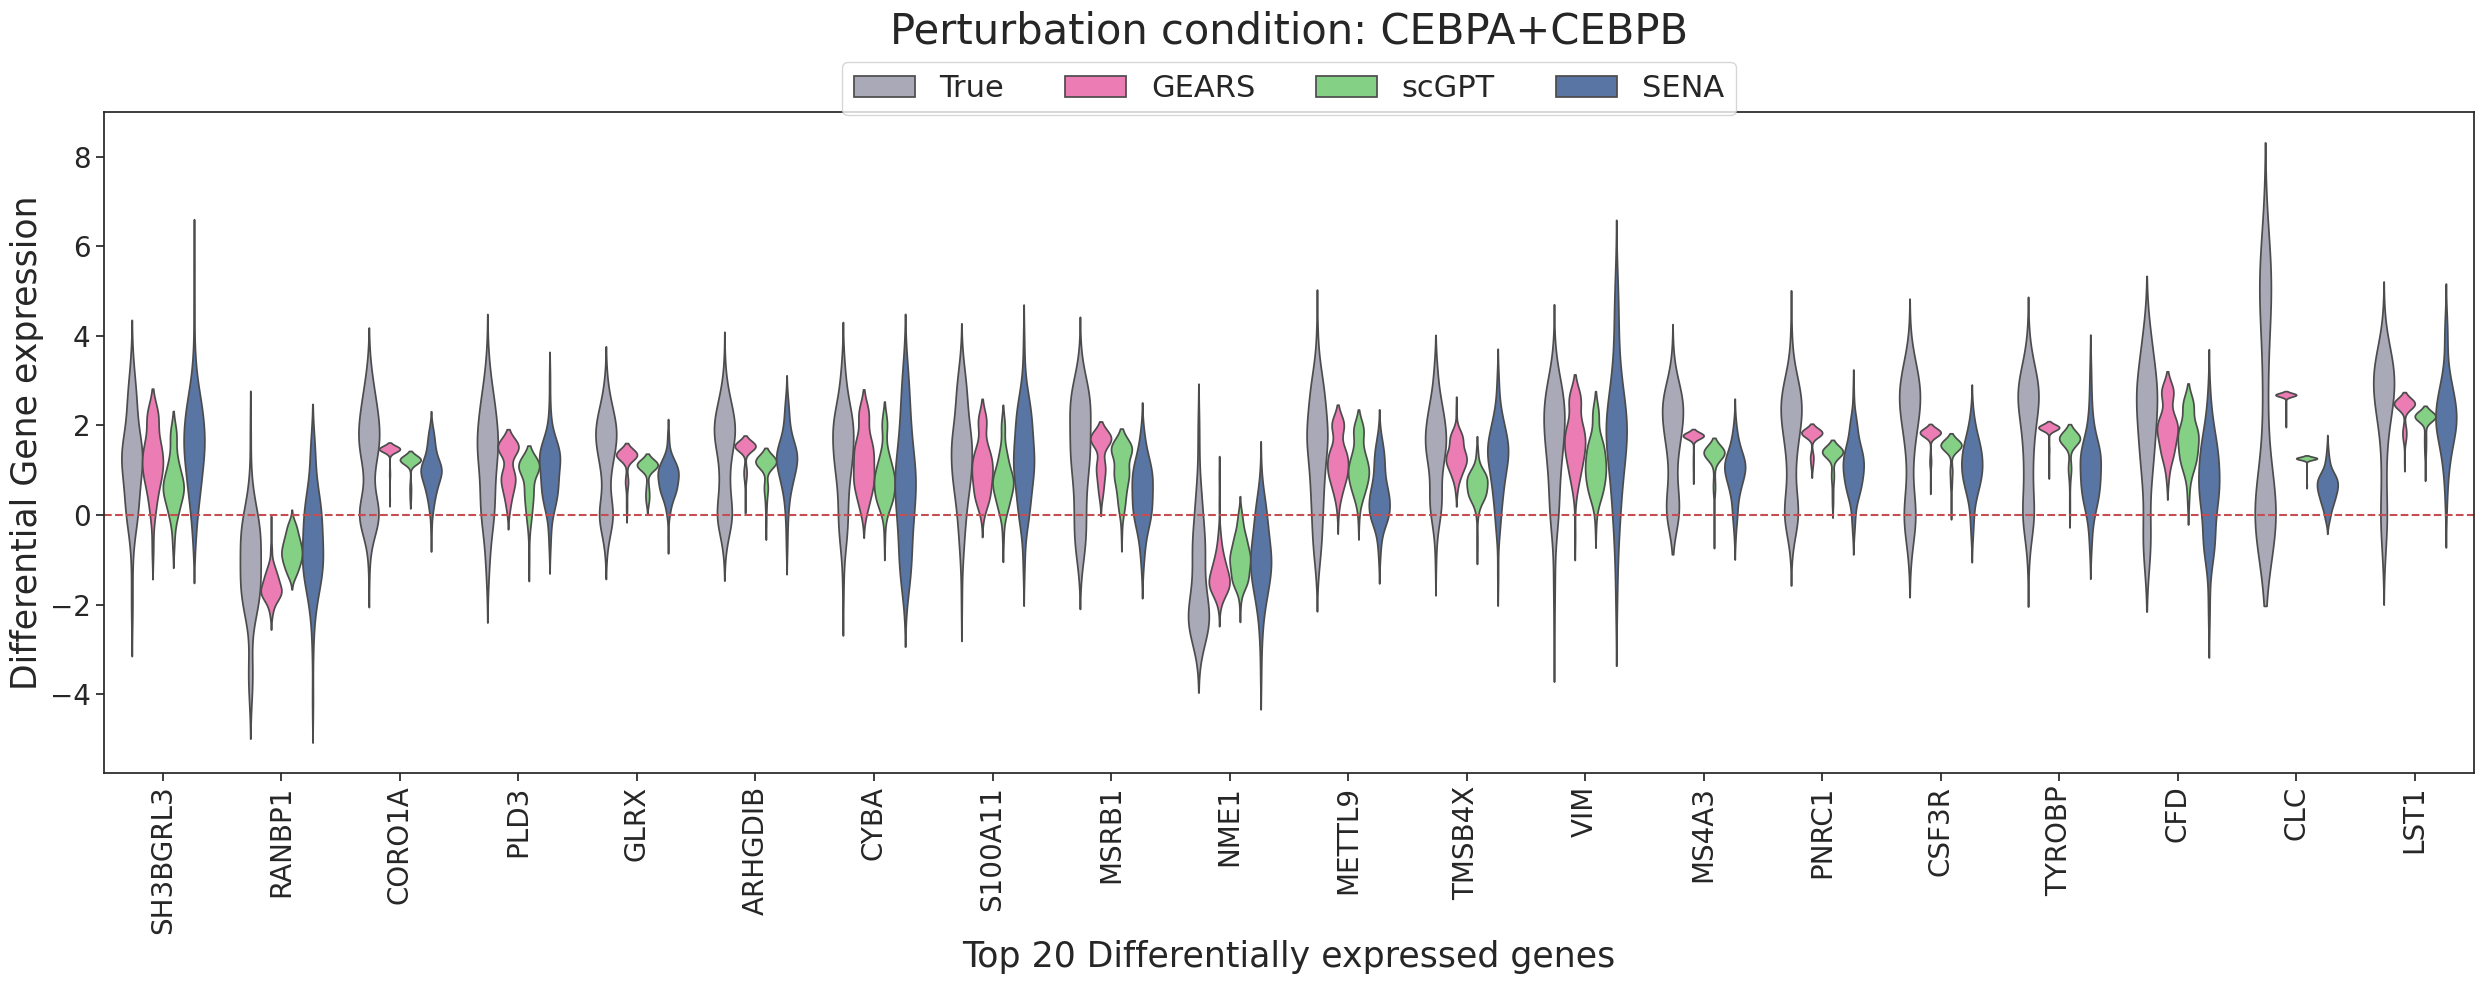

In [68]:
# Trying adding more
plot_top_degs(new_df, condition, top_deg_to_plot, custom_palette=custom_palette)

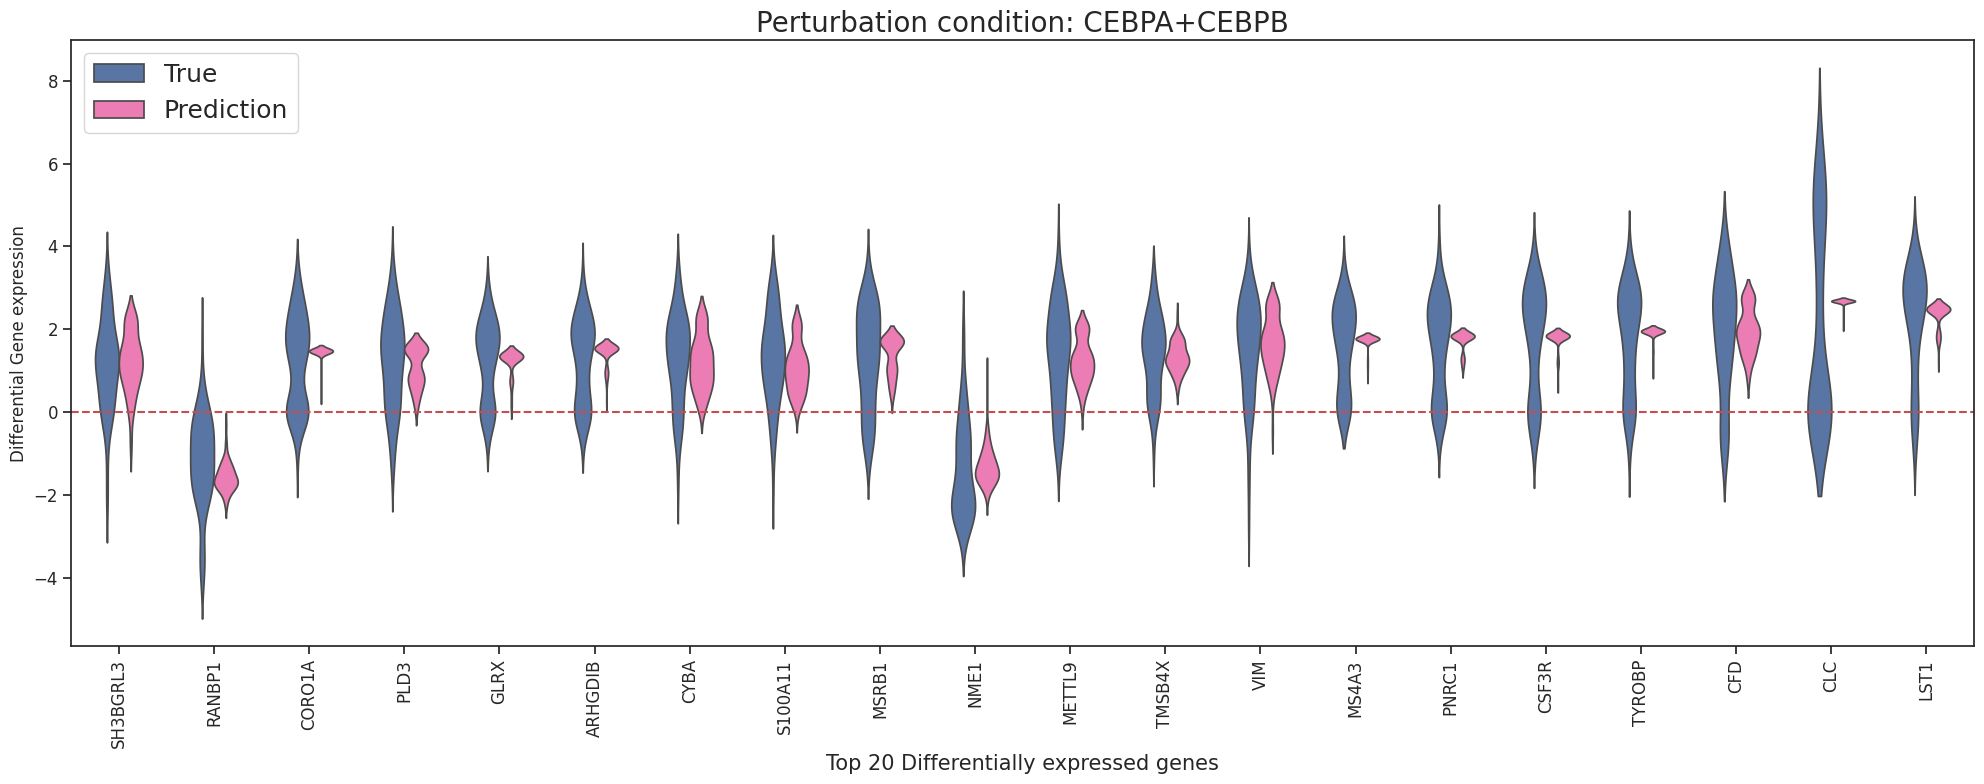

In [ ]:
plot_top_degs(deg_df, condition, top_deg_to_plot)

###

In [ ]:
# Pseudobulked adata object
if prediction_type == 'double':
    adata_cond = adata[adata.obs['condition_fixed'].str.contains('+', regex=False)].copy()
    sc.pp.highly_variable_genes(adata_cond, n_top_genes=top_hvg)
    unique_conds = adata_cond.obs.groupby('condition_fixed').groups


# Calculate mean expression per condition
adata_pseudobulked = []
for condition, idx_labels in unique_conds.items():
    idx = adata_cond.obs.index.get_indexer(idx_labels)
    cond_mean = np.asarray(adata_cond.X[idx].mean(axis=0)).flatten()
    adata_pseudobulked.append(pd.Series(cond_mean, index=adata.var_names, name=condition))

adata_pbk = pd.DataFrame(adata_pseudobulked)

In [62]:
true_dge = adata_pbk - baseline_control

In [ ]:
# Keep going with predictions
pred_df = pd.read_csv(path_to_pred)
pred_df['double'] = pred_df['double'].str.replace("_","+")

,double,ENSG00000239945,ENSG00000223764,ENSG00000187634,ENSG00000187642,ENSG00000188290,ENSG00000187608,ENSG00000273443,ENSG00000237330,ENSG00000223823,...,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727,ENSG00000273554,ENSG00000278633
0,TBX3+TBX2,0.000023,0.003167,0.018618,0.000199,0.163202,0.314495,-1.031418e-11,0.249496,1.780868e-20,...,4.086853,5.148991,3.686456,1.085554,4.526010,2.039971,1.528167,3.863174,0.002250,-0.000050
1,SNAI1+UBASH3B,0.000018,0.013407,0.043168,0.000252,0.230553,0.295827,-8.107853e-13,0.256798,-3.817165e-21,...,4.055546,5.111433,3.519061,1.162422,4.444243,2.118717,1.508468,3.688512,0.002349,0.000021
2,FOXA1+FOXL2,0.000018,0.034383,0.087679,0.000387,0.227548,0.429410,1.789824e-11,0.171411,-4.034800e-20,...,3.969291,5.033115,3.486370,1.169689,4.376147,2.027290,1.466616,3.614317,0.014798,0.000081
3,UBASH3B+UBASH3A,0.000018,0.012027,0.028492,0.000209,0.217931,0.340728,-5.841441e-13,0.212173,-3.738612e-21,...,4.047687,5.141636,3.523916,1.150716,4.467142,2.113990,1.550613,3.718475,0.001979,0.000006
4,CEBPE+CEBPA,0.000040,0.120945,0.268068,0.000902,0.086143,0.461857,7.684330e-11,0.218488,-1.448724e-19,...,3.983280,5.052023,3.633809,0.977758,4.375730,1.709917,0.981365,3.704039,0.010548,0.000257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,LYL1+CEBPB,0.000024,0.049256,0.102723,0.000340,0.195582,0.399183,3.384410e-11,0.070116,-6.632183e-20,...,4.066959,5.115145,3.602071,1.160132,4.483344,2.051719,1.410941,3.749188,0.004397,0.000068
124,CEBPB+PTPN12,0.000022,0.041848,0.105332,0.000445,0.182490,0.367270,1.474776e-11,0.141551,-3.395170e-20,...,4.008665,5.086886,3.550052,1.176733,4.406981,2.026643,1.335576,3.670967,0.008857,0.000101
125,BCL2L11+TGFBR2,0.000018,0.002246,0.001571,0.000095,0.247031,0.322760,-4.066271e-12,0.059263,2.502015e-21,...,4.024642,5.080443,3.508912,1.217887,4.424167,2.164337,1.576641,3.653398,0.000535,-0.000022
126,CBL+UBASH3B,0.000020,0.015571,0.027663,0.000229,0.271832,0.342154,-1.450340e-12,0.309318,-1.404735e-21,...,4.036441,5.143408,3.517428,1.129435,4.444511,2.098381,1.542826,3.684778,0.004907,0.000004


In [94]:
true_dge_keep = true_dge[top_gene_names]
true_dge_keep.insert(0, 'double', true_dge.index)
true_dge_keep

gene_id,double,ENSG00000143839,ENSG00000157150,ENSG00000230401,ENSG00000169429,ENSG00000227507,ENSG00000204389,ENSG00000135346,ENSG00000235314,ENSG00000275896,...,ENSG00000271933,ENSG00000185559,ENSG00000197943,ENSG00000264451,ENSG00000100985,ENSG00000099860,ENSG00000105205,ENSG00000188064,ENSG00000160180,ENSG00000160182
AHR+FEV,AHR+FEV,0.000000,0.001627,-0.000999,-0.000633,-0.003721,-0.025678,0.0,0.008786,0.003010,...,0.000738,-0.001203,0.037025,-0.000842,0.000760,-0.013920,0.005724,-0.000517,-0.000235,0.000000
AHR+KLF1,AHR+KLF1,0.000000,-0.000464,-0.000999,-0.000633,0.196514,-0.047093,0.0,-0.001707,-0.000186,...,-0.000451,-0.001203,-0.064649,0.004826,-0.002458,-0.003067,-0.001853,-0.000517,-0.000235,0.000000
BAK1+BCL2L11,BAK1+BCL2L11,0.000000,-0.000464,0.002642,-0.000633,-0.003667,-0.028999,0.0,-0.001707,-0.000186,...,0.007362,-0.001203,-0.030441,-0.000842,-0.002458,0.002480,-0.005560,-0.000517,-0.000235,0.000000
BAK1+KLF1,BAK1+KLF1,0.000000,-0.000464,-0.000999,-0.000633,0.014725,-0.048624,0.0,0.000980,-0.000186,...,-0.001664,-0.001203,0.037608,-0.000842,-0.001152,-0.005914,-0.000767,-0.000517,-0.000235,0.000000
BAK1+TMSB4X,BAK1+TMSB4X,0.000000,-0.000464,-0.000999,-0.000633,0.007347,0.008177,0.0,-0.001707,-0.000186,...,-0.001664,-0.001203,0.023464,0.002993,-0.002458,-0.000862,-0.004418,-0.000517,-0.000235,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNAI1+UBASH3B,SNAI1+UBASH3B,0.014787,-0.000464,0.000990,-0.000633,-0.011069,-0.081022,0.0,0.006471,-0.000186,...,-0.001664,-0.001203,-0.030918,-0.000842,-0.002458,-0.016492,-0.010137,-0.000517,-0.000235,0.000000
SNAI1+ZBTB10,SNAI1+ZBTB10,0.000000,-0.000464,-0.000999,-0.000633,0.004464,-0.021369,0.0,0.028589,-0.000186,...,-0.001664,0.065189,-0.044926,-0.000842,0.009014,-0.023398,0.001288,-0.000517,-0.000235,0.000000
TBX2+TBX3,TBX2+TBX3,0.004823,-0.000464,-0.000999,-0.000633,-0.003084,-0.092510,0.0,0.002588,-0.000186,...,-0.000963,0.005833,-0.018484,0.002768,-0.001211,-0.006534,-0.001607,-0.000015,-0.000235,0.000000
UBASH3A+UBASH3B,UBASH3A+UBASH3B,0.000000,-0.000464,-0.000999,0.002551,-0.004482,-0.016167,0.0,0.000070,-0.000186,...,-0.000228,-0.001203,-0.009563,0.001019,-0.000863,-0.006703,0.005827,0.000970,0.001795,0.001423


In [95]:
dge_pred = pred_df.iloc[:, 1:] - baseline_control
dge_pred_keep = dge_pred[top_gene_names]
dge_pred_keep.insert(0, 'double', pred_df['double'])
dge_pred_keep

,double,ENSG00000143839,ENSG00000157150,ENSG00000230401,ENSG00000169429,ENSG00000227507,ENSG00000204389,ENSG00000135346,ENSG00000235314,ENSG00000275896,...,ENSG00000271933,ENSG00000185559,ENSG00000197943,ENSG00000264451,ENSG00000100985,ENSG00000099860,ENSG00000105205,ENSG00000188064,ENSG00000160180,ENSG00000160182
0,TBX3+TBX2,0.011281,0.000900,0.004048,0.117771,-0.114825,-0.060845,0.013089,0.014947,0.005563,...,-0.000401,0.059617,0.154302,0.010633,0.024622,-0.017295,0.184148,0.001617,0.030369,0.001740
1,SNAI1+UBASH3B,0.008598,0.000860,0.004780,0.020294,-0.022578,-0.023474,0.009745,0.021832,0.008525,...,-0.001370,0.016061,0.020311,0.007750,0.009551,-0.023466,-0.015504,0.000231,0.025203,0.007170
2,FOXA1+FOXL2,0.019725,0.000016,0.000933,0.030476,0.236837,-0.054965,0.010841,0.006659,0.036800,...,0.010402,0.037361,0.055038,0.024759,0.046478,-0.000891,0.267112,0.008341,0.057568,0.021441
3,UBASH3B+UBASH3A,0.006396,0.000678,0.004789,0.019773,-0.026510,0.013361,0.007784,0.016298,0.011356,...,-0.001789,0.013747,0.024617,0.011271,0.002633,-0.031820,-0.028000,0.000245,0.019919,0.005479
4,CEBPE+CEBPA,0.028038,0.000572,-0.002817,0.039080,0.651315,0.063083,0.025127,0.022807,0.053701,...,0.047625,0.057576,0.391454,0.100462,0.277692,0.163426,2.674452,0.011419,0.071793,0.037148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,LYL1+CEBPB,0.008360,-0.000050,0.000098,0.009385,0.319220,0.026046,0.007076,0.009211,0.039251,...,0.018382,0.021183,0.128879,0.037113,0.088492,0.049145,0.818173,0.008480,0.024095,0.013726
124,CEBPB+PTPN12,0.015582,0.000055,0.003562,0.021950,0.218563,-0.015529,0.012045,0.010419,0.032515,...,0.017881,0.025996,0.129483,0.033570,0.084032,0.045202,0.771096,0.006243,0.043057,0.019229
125,BCL2L11+TGFBR2,-0.000588,0.000080,0.000333,0.002940,0.038877,0.000665,0.001363,0.010218,0.013300,...,-0.004000,-0.002390,-0.022636,0.002393,-0.006397,-0.024483,-0.127698,0.000319,0.001571,0.000380
126,CBL+UBASH3B,0.007297,0.001315,0.004557,0.023320,-0.084484,0.013230,0.010850,0.029878,-0.001124,...,-0.004159,0.009766,0.052209,0.005764,0.001113,-0.033752,-0.031881,-0.000356,0.021058,0.004184


## Comparing distributions for these genes

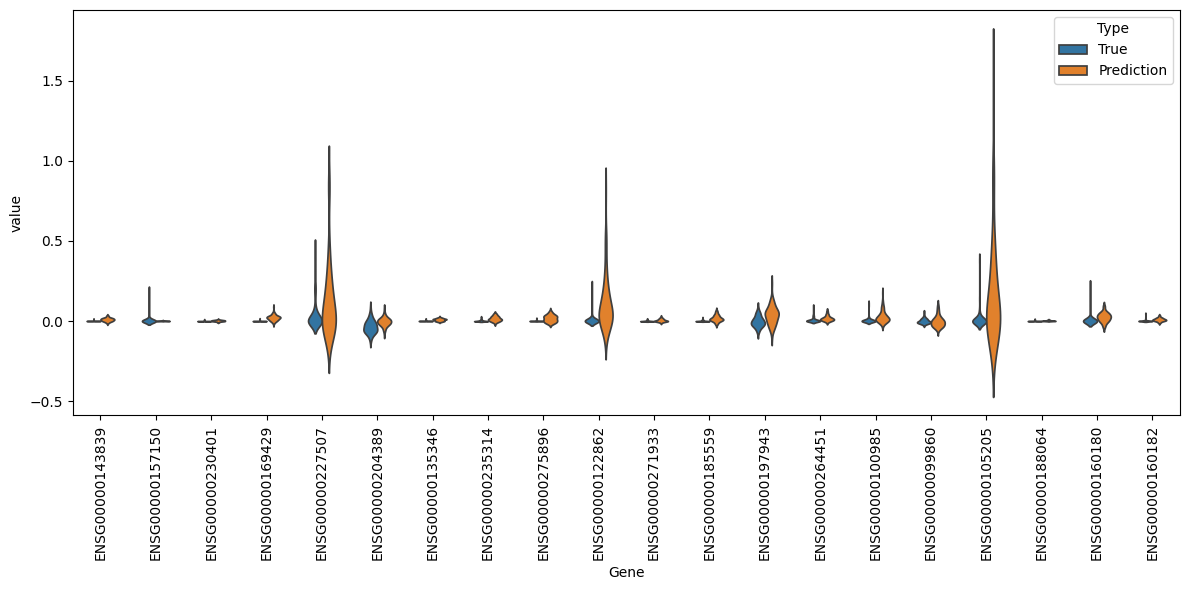

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

common_names = set(true_dge_keep['double']) & set(dge_pred_keep['double'])

true = true_dge_keep[true_dge_keep['double'].isin(common_names)].copy()
pred = dge_pred_keep[dge_pred_keep['double'].isin(common_names)].copy()

true['Type'] = 'True'
pred['Type'] = 'Prediction'

# Concatenate
fused_df = pd.concat([true, pred])

# Melt the DataFrame so you have long-form format for Seaborn
melted = fused_df.melt(id_vars=['double', 'Type'], var_name='Gene', value_name='value')

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=melted, x='Gene', y='value', hue='Type', split=False, inner=None, width=0.5, density_norm='width')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
